In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import networkx as nx
import time

In [2]:
path = 'data/wiki-Vote.txt'
G = nx.read_edgelist(path, delimiter='\t', create_using=nx.DiGraph, nodetype=int)
A = nx.linalg.graphmatrix.adjacency_matrix(G)
print(nx.info(G))

node_target = 9

# plot matrix
#plt.spy(A,marker=',')
#plt.show()

Name: 
Type: DiGraph
Number of nodes: 7115
Number of edges: 103689
Average in degree:  14.5733
Average out degree:  14.5733


Elapsed time:  0.115689 seconds


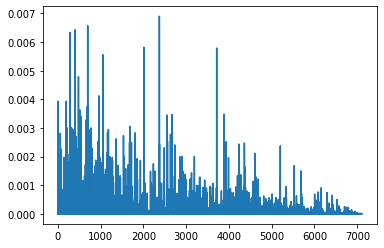

In [3]:
#compute PageRank algorith with power iteration (from network science)
def pageRank(M, t, iterations):
    N = M.shape[1]
    c = 0.85
    p = np.ones(N)/N

    for i in range(iterations):
        p = c * M * p + (1-c) * t #pagerank formula
        p = p/sum(p) #normalization

    return p


# dimension of the matrix
N = A.shape[0]

# for normal pagerank all nodes have the same teleport probability
# t = np.ones(N)/N 

# for local pagerank only a subset of nodes have non-negative probabilty
t = np.zeros(N)
t[9] = 1

start = time.time()
p = pageRank(A, t, 40)
stop = time.time()
print('Elapsed time: ', str(stop-start)[0:8], 'seconds')
plt.plot(p)
plt.show()

In [4]:
def push(G, node_u, p, r, d, alpha):

    pi = p
    ri = r
    pi[node_u] = p[node_u] + alpha * r[node_u]
    ri[node_u] = (1-alpha) * r[node_u] / 2

    for node_v in G.successors(node_u):
        ri[node_v] = r[node_v] + (1-alpha) * r[node_u] / (2 * d[node_u])

    return pi, ri

In [7]:
def approximatePageRank(G, target_node, alpha, epsilon):

    nodes = list(G.nodes())
    nodes_vector = np.array(nodes)

    #pagerank
    p = {}
    for n in nodes:
        p[n] = 0

    #residuals
    r = {}
    for n in nodes:
        r[n] = 0
    r[target_node] = 1
    r_vector = np.array(list(r.values()))

    #degrees
    d = {}
    for n in nodes:
        d[n] = G.out_degree(n)
    d_vector = np.array(list(d.values()))

    valid_nodes = np.nonzero(d_vector)[0]
    stopping_condition = (r_vector[valid_nodes] / d_vector[valid_nodes]) >= epsilon
    queue = nodes_vector[valid_nodes][stopping_condition]    

    while(any(stopping_condition)):
        u = queue[0]
        p, r = push(G, u, p, r, d, alpha)
        r_vector = np.array(list(r.values()))
        stopping_condition = (r_vector[valid_nodes] / d_vector[valid_nodes]) >= epsilon
        #stopping_condition = r_vector >= epsilon
        queue = nodes_vector[valid_nodes][stopping_condition]
        #queue = np.array(nodes)[stopping_condition]

    p_vector = list(p.values())
    #print(p)

    # normalize pageRank vector
    P = sum(p_vector)
    p_vector = np.array(p_vector)/P
    p_vector[np.argmax(p_vector)] = 0

    return p_vector

Elapsed time: 0.784412 seconds


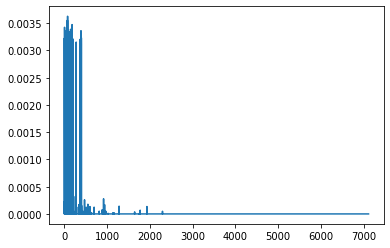

In [8]:
start = time.time()
pg = approximatePageRank(G, node_target, 0.15, 1e-5)
stop = time.time()
print('Elapsed time:', str(stop-start)[0:8], 'seconds')
plt.plot(pg)
plt.show()

Elapsed time: 1.756749 seconds


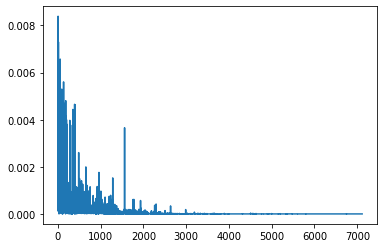

In [9]:
start = time.time()
p = nx.pagerank(G, personalization={node_target:1}, max_iter=40, weight=None)
#p = nx.pagerank(G, personalization={9:1}, max_iter=40, weight=None, tol=1e-2, alpha=0.85)
stop = time.time()
print('Elapsed time:', str(stop-start)[0:8], 'seconds')
p = list(p.values())
p[np.argmax(p)] = 0
plt.plot(p)
plt.show()